In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import socket

# 设定路径
data_dir = "/root/CV_2_lab1/lab2/processed_data"  # 替换为你的路径
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据集
def load_dataset(pt_path):
    images, labels = torch.load(pt_path)
    return TensorDataset(images, labels)

train_dataset = load_dataset(os.path.join(data_dir, "train_data.pt"))
val_dataset = load_dataset(os.path.join(data_dir, "val_data.pt"))
test_dataset = load_dataset(os.path.join(data_dir, "test_data.pt"))

# 类别数
_, train_labels = torch.load(os.path.join(data_dir, "train_data.pt"))
num_classes = len(set(train_labels.tolist()))
print(f"Number of classes: {num_classes}")


Using device: cpu
Number of classes: 102


In [2]:
# 构建模型
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# 训练函数
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step() if phase == "train" else None

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, best_acc.item()

# Top-k 评估函数
def evaluate_model(model, dataloader, top_k=5):
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.topk(outputs, top_k, 1, True, True)
            corrects += torch.sum(preds.eq(labels.view(-1, 1))).item()
            total += labels.size(0)

    return corrects / total

# 计算 top-1 到 top-5 准确率分布（在验证集上）
def evaluate_topk_ranks(model, dataloader, k=5):
    model.eval()
    rank_hits = [0] * k
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, topk_preds = torch.topk(outputs, k, dim=1)
            for i in range(k):
                rank_hits[i] += (topk_preds[:, i] == labels).sum().item()
            total += labels.size(0)

    return [round(hit / total, 4) for hit in rank_hits]


print("Done!")
print("Hostname:", socket.gethostname())

Done!
Hostname: iZuf68fgu291f8pkjwzxreZ


In [3]:
def run_grid_search(train_dataset, val_dataset, test_dataset):
    results = []
    lr_list = [0.001, 0.01]
    bs_list = [32, 64]
    epoch_list = [10, 20]

    for lr in lr_list:
        for bs in bs_list:
            for epochs in epoch_list:
                print(f"\nTraining: lr={lr}, bs={bs}, epochs={epochs}")
                model = build_model(num_classes)

                optimizer = optim.SGD([
                    {"params": model.fc.parameters(), "lr": lr},
                    {"params": [p for n, p in model.named_parameters() if "fc" not in n], "lr": lr / 10}
                ], momentum=0.9)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
                criterion = nn.CrossEntropyLoss()

                train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
                val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=2)
                test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)

                dataloaders = {"train": train_loader, "val": val_loader}
                dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

                model, best_val_acc = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=epochs)
                
                # Top-1 test accuracy
                test_accuracy = evaluate_model(model, test_loader, top_k=1)
                print(f"Test Accuracy (Top-1): {test_accuracy:.4f}")

                # Top-5 rank stats on val set
                top5_val_preds = evaluate_topk_ranks(model, val_loader, k=5)

                results.append({
                    "lr": lr,
                    "batch_size": bs,
                    "epochs": epochs,
                    "test_accuracy": round(test_accuracy, 4),
                    "top_5_val_preds": top5_val_preds
                })
    return results

print("Done!!")

Done!!


Start trainig...

Training: lr=0.001, bs=32, epochs=10
Epoch 1/10
Train Acc: 0.2725
Val Acc: 0.4041
Epoch 2/10
Train Acc: 0.4739
Val Acc: 0.5412
Epoch 3/10
Train Acc: 0.5945
Val Acc: 0.6317
Epoch 4/10
Train Acc: 0.6727
Val Acc: 0.6798
Epoch 5/10
Train Acc: 0.7272
Val Acc: 0.7141
Epoch 6/10
Train Acc: 0.7627
Val Acc: 0.7454
Epoch 7/10
Train Acc: 0.7948
Val Acc: 0.7593
Epoch 8/10
Train Acc: 0.7977
Val Acc: 0.7593
Epoch 9/10
Train Acc: 0.8003
Val Acc: 0.7622
Epoch 10/10
Train Acc: 0.8047
Val Acc: 0.7615
Test Accuracy (Top-1): 0.7822

Training: lr=0.001, bs=32, epochs=20
Epoch 1/20
Train Acc: 0.2755
Val Acc: 0.3968
Epoch 2/20
Train Acc: 0.4706
Val Acc: 0.5368
Epoch 3/20
Train Acc: 0.5903
Val Acc: 0.6229
Epoch 4/20
Train Acc: 0.6673
Val Acc: 0.6791
Epoch 5/20
Train Acc: 0.7278
Val Acc: 0.7082
Epoch 6/20
Train Acc: 0.7669
Val Acc: 0.7381
Epoch 7/20
Train Acc: 0.7933
Val Acc: 0.7462
Epoch 8/20
Train Acc: 0.8019
Val Acc: 0.7571
Epoch 9/20
Train Acc: 0.8017
Val Acc: 0.7564
Epoch 10/20
Train Acc

,lr,batch_size,epochs,test_accuracy,top_5_accuracy
5,0.010,32,20,0.8718,"[0.857, 0.0897, 0.016, 0.008, 0.0029]"
4,0.010,32,10,0.8572,"[0.8534, 0.0963, 0.016, 0.0051, 0.0029]"
7,0.010,64,20,0.8558,"[0.8476, 0.0941, 0.019, 0.008, 0.0058]"
6,0.010,64,10,0.8558,"[0.8403, 0.1072, 0.0146, 0.0088, 0.008]"
1,0.001,32,20,0.7873,"[0.7702, 0.1386, 0.0299, 0.0146, 0.0066]"
0,0.001,32,10,0.7822,"[0.7622, 0.1444, 0.0306, 0.0109, 0.0095]"
2,0.001,64,10,0.6672,"[0.6346, 0.1503, 0.0525, 0.0343, 0.0255]"
3,0.001,64,20,0.6628,"[0.6586, 0.151, 0.0438, 0.0284, 0.0197]"


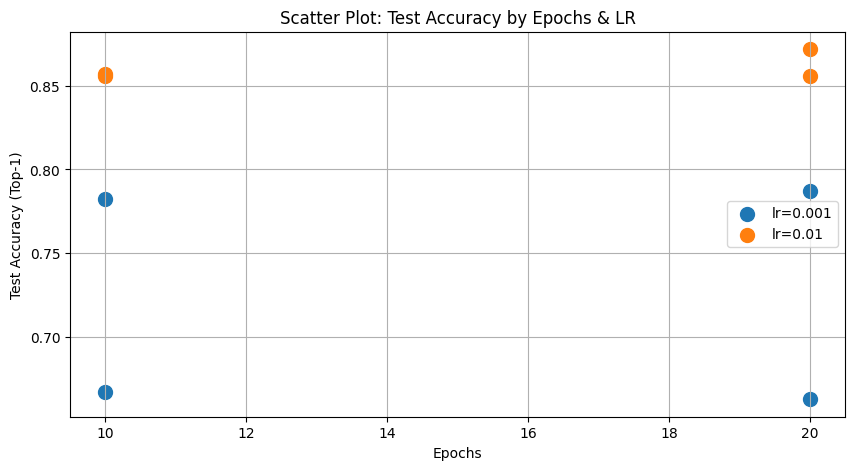

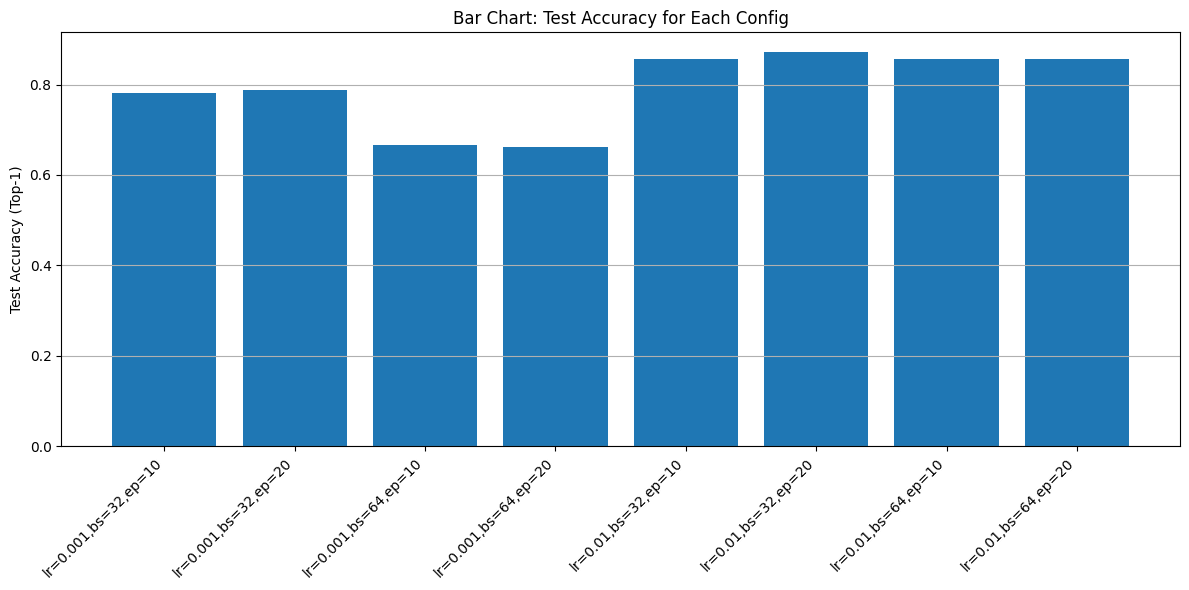

Results saved to finetune_results.csv


In [4]:
import csv

# 保存为 DataFrame、画图、导出 CSV
def visualize_results(results, output_csv_path="finetune_results.csv"):
    # 创建 DataFrame
    df = pd.DataFrame(results)
    df.rename(columns={
        "test_accuracy": "test_accuracy", 
        "top_5_val_preds": "top_5_accuracy"
    }, inplace=True)

    # 展示按 test_accuracy 排序后的表格
    display(df.sort_values(by="test_accuracy", ascending=False))

    # 散点图：Test Accuracy vs Epochs, grouped by LR
    plt.figure(figsize=(10, 5))
    for lr in df["lr"].unique():
        subset = df[df["lr"] == lr]
        plt.scatter(subset["epochs"], subset["test_accuracy"], label=f"lr={lr}", s=100)
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (Top-1)")
    plt.title("Scatter Plot: Test Accuracy by Epochs & LR")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 柱状图：不同组合的 Test Accuracy
    plt.figure(figsize=(12, 6))
    labels = [f"lr={row.lr},bs={row.batch_size},ep={row.epochs}" for _, row in df.iterrows()]
    plt.bar(labels, df["test_accuracy"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Test Accuracy (Top-1)")
    plt.title("Bar Chart: Test Accuracy for Each Config")
    plt.tight_layout()
    plt.grid(axis="y")
    plt.show()

    # 导出 CSV
    df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return df

print("Start trainig...")
results = run_grid_search(train_dataset, val_dataset, test_dataset)
df_results = visualize_results(results)